In [2]:
#Initialisation
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

#load the curves to fit
target_curves = np.load('target_curves.npy')

PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

Input file: Random_nodes_12_mech_100_of_10000_curve_0.npy numer of mechanisms: 100
Best Distance Performance In random population: 0.3512207865715027
Best Material Performance In random population: 7.324190616607666

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       68 |      1 |  1.8269181252 |  4.7998747282 |             - |             -
     2 |      136 |      1 |  1.8269181252 |  4.7893755734 |             - |             -
     3 |      204 |      1 |  1.8269181252 |  4.7893755734 |             - |             -
     4 |      272 |      1 |  1.8269181252 |  4.7893755734 |             - |             -
     5 |      340 |      1 |  1.8269181252 |  4.7893755734 |             - |             -
     6 |      408 |      1 |  1

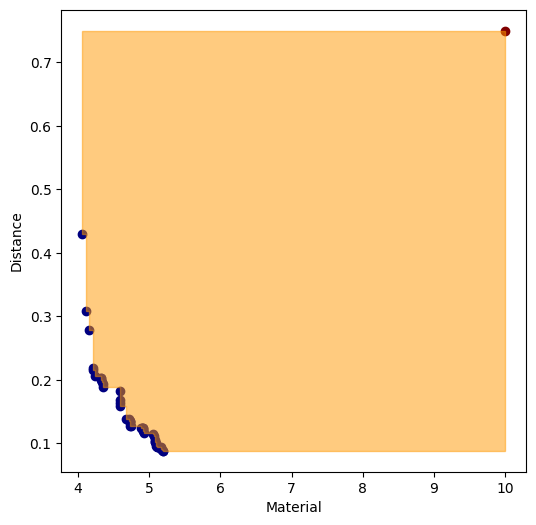

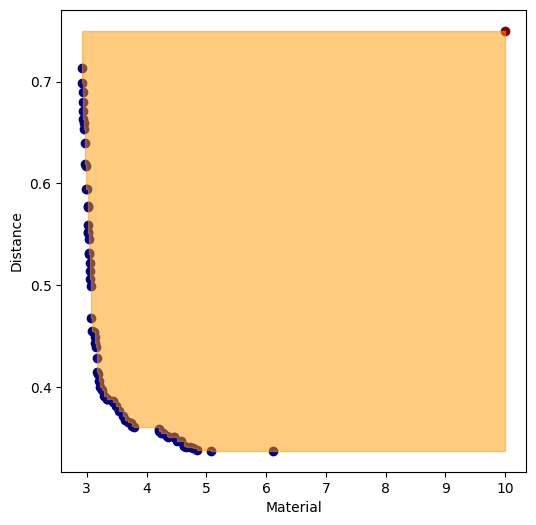

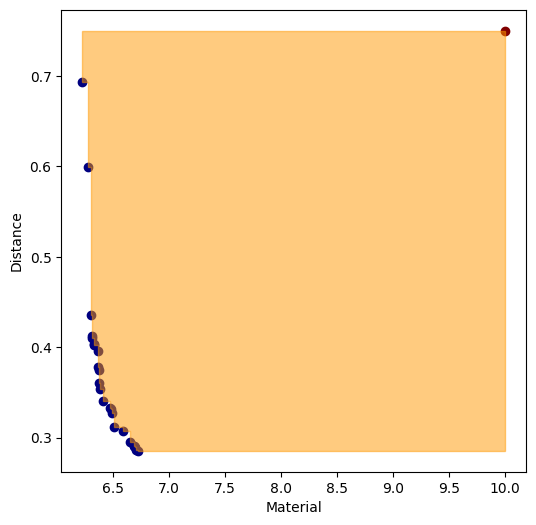

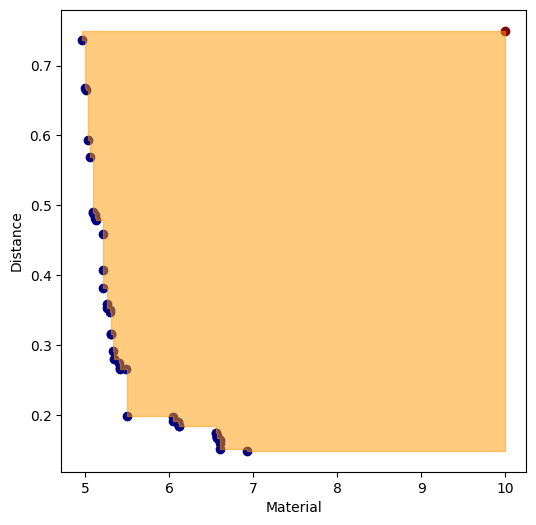

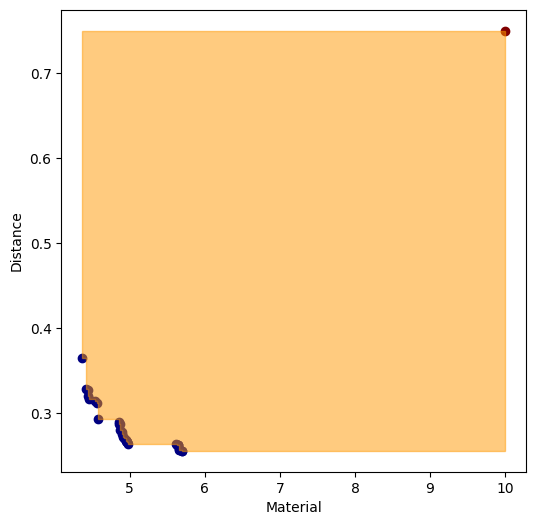

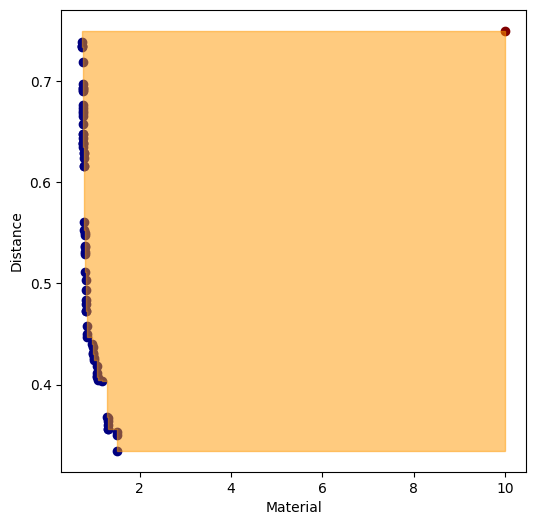

In [5]:
# Genetic Algorithm Optimisation
# from pymoo.algorithms.moo.rnsga2 import RNSGA2

''' INIT '''
from utils.mechanism_io import load_mechanisms, save_mechanisms

''' INIT End '''


''' Setup '''
NUM_OF_NODES = 12
NUM_OF_MECH = 100
NUM_INIT_MECH = NUM_OF_MECH*100
NUM_OF_GENERATIONS = 1000

ONLY_FIRST_CURVE = False
if ONLY_FIRST_CURVE:
        curves = [0]
else:
        curves = range(target_curves.shape[0])

TAKE_RANDOM = True
if TAKE_RANDOM:
    file_name= f'Random_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_of_{NUM_INIT_MECH}'
''' Setup End '''

results = []
for curve_index in curves:
        mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
        print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))

        problem = mechanism_synthesis_optimization(target_curves[curve_index], N=NUM_OF_NODES)

        initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

        class sample_from_random(Sampling):
                def _do(self, problem, n_samples, **kwargs):
                        return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

        F = problem.evaluate(np.array(initial_population))[0]
        print(f'Best Distance Performance In random population: {F[:,0].min()}')
        print(f'Best Material Performance In random population: {F[:,1].min()}')

        algorithm = NSGA2(pop_size=68,
                        sampling=sample_from_random(),
                        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                        mutation=PolynomialMutation(prob=0.5),
                        eliminate_duplicates=MixedVariableDuplicateElimination())

        results.append(minimize(problem,
                        algorithm,
                        ('n_gen', NUM_OF_GENERATIONS),
                        verbose=True,
                        save_history=True,
                        seed=123
                        ))
        
        # algorithm = RNSGA2(
        #         pop_size=100,
        #         ref_points=np.atleast_2d(ref_point),
        #         sampling=sample_from_random(),
        #         mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
        #         mutation=PolynomialMutation(prob=0.5),
        #         eliminate_duplicates=MixedVariableDuplicateElimination()
        #         )
                
        #         results = minimize(
        #         problem,
        #         algorithm,
        #         ('n_gen', 100),
        #         verbose=True,
        #         save_history=True,
        #         seed=123
        # )

        if not results[curve_index].X is None:
                #Specify reference point
                ref_point = np.array([0.75, 10.0])

                #Calculate Hypervolume
                ind = HV(ref_point)
                hypervolume = ind(results[curve_index].F)

                #Print and plot
                print('Hyper Volume ~ %f' %(hypervolume))
                ga_visualizer.plot_HV(results[curve_index].F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
        else:
                print('Did Not Find Solutions!!')


# Write results from GA to file
for curve_index in curves:
    # add out population to submission
    mechanisms = []
    if not results[curve_index].X is None:
        for j in range(results[curve_index].X.shape[0]):
            if not isinstance(results[curve_index].X, dict):
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X[j])
            else:
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                #'target_joint': target_idx # ignore for now
            }
            mechanisms.append(mech)
    file_name_temp = f'GA_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_NUM_OF_GENERATIONS_{NUM_OF_GENERATIONS}'
    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    print(file_name)
file_name = file_name_temp
print(len(mechanisms))


In [6]:
print(len(mechanisms))

68


Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_0.npy numer of mechanisms: 50


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0
Hypervolume before gradient optimization: 0.0000, after optimization:  0.0000, combined:  0.0000
Saved 100 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_0.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000
Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_1.npy numer of mechanisms: 68


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 9
Hypervolume before gradient optimization: 2.8271, after optimization:  2.6907, combined:  2.8292
Saved 136 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_1.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000
Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_2.npy numer of mechanisms: 24


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0
Hypervolume before gradient optimization: 0.0000, after optimization:  0.0000, combined:  0.0000
Saved 48 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_2.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000
Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_3.npy numer of mechanisms: 42


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 6
Hypervolume before gradient optimization: 2.8316, after optimization:  2.7281, combined:  2.8689
Saved 84 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_3.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000
Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_4.npy numer of mechanisms: 33


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 5
Hypervolume before gradient optimization: 2.7512, after optimization:  1.0508, combined:  2.7746
Saved 66 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_4.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000
Input file: GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000_curve_5.npy numer of mechanisms: 68


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 6
Hypervolume before gradient optimization: 3.7806, after optimization:  3.7805, combined:  3.7817
Saved 136 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_5.npy
GA_nodes_12_mech_100_NUM_OF_GENERATIONS_1000


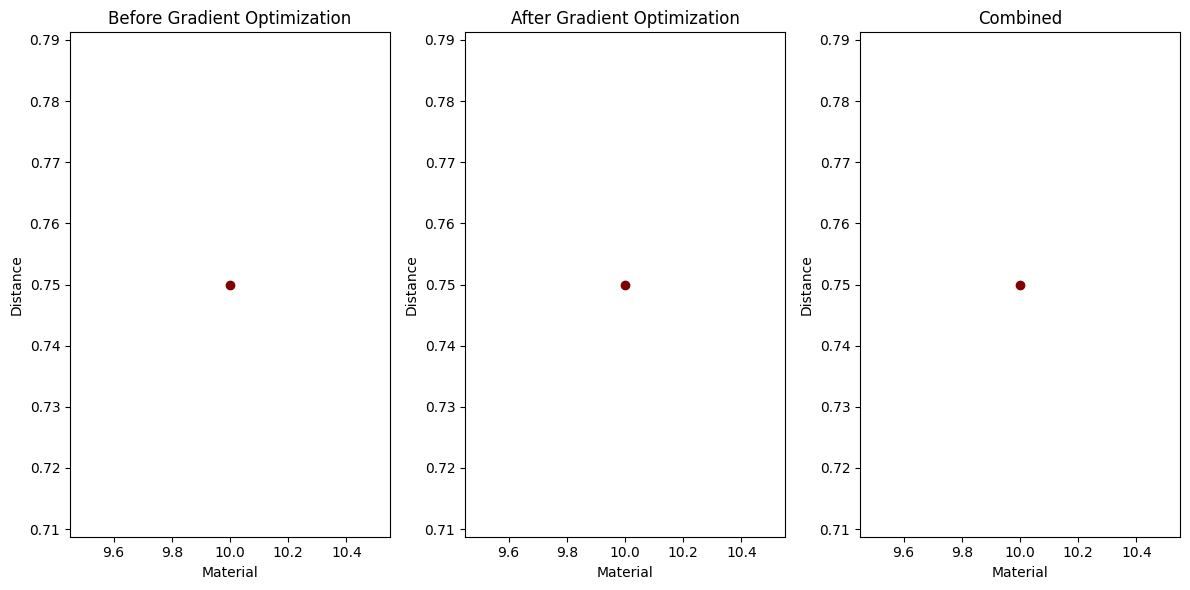

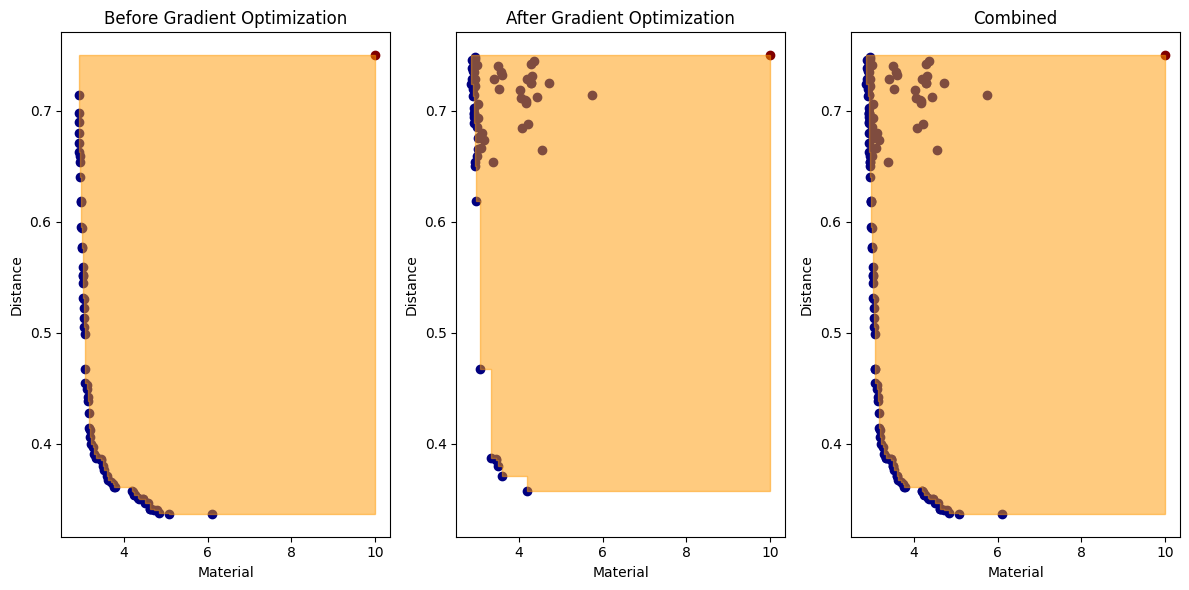

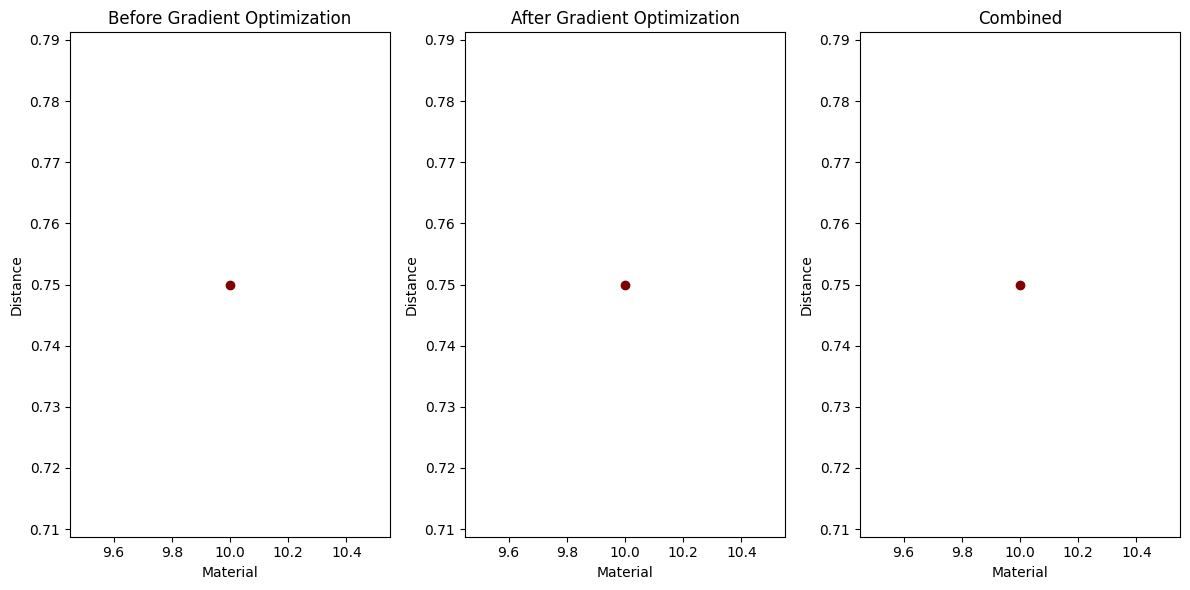

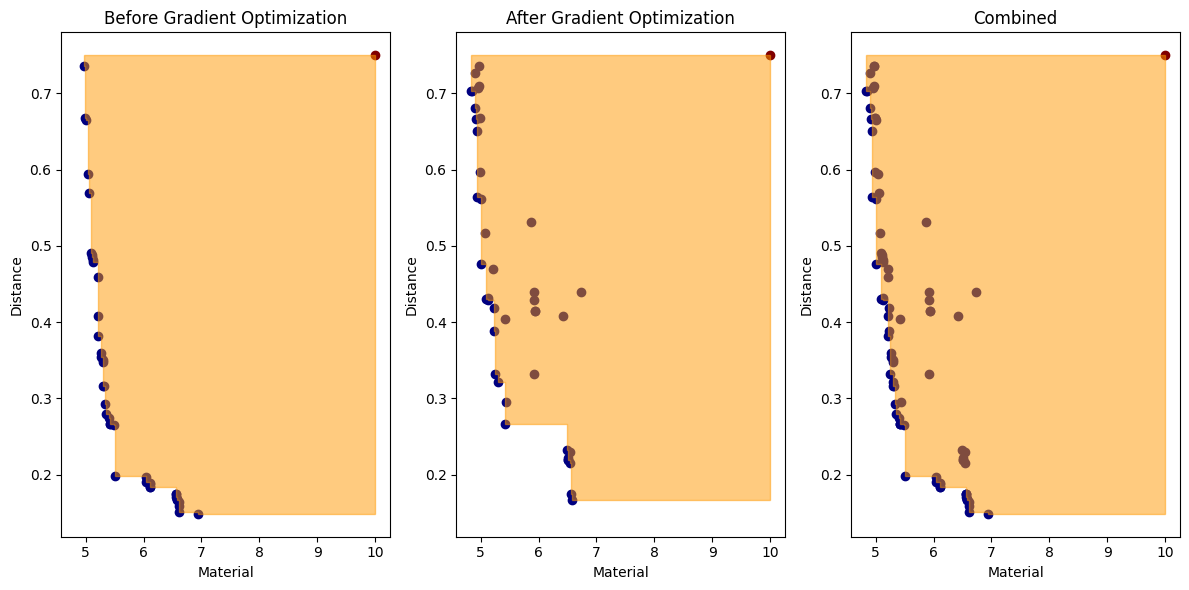

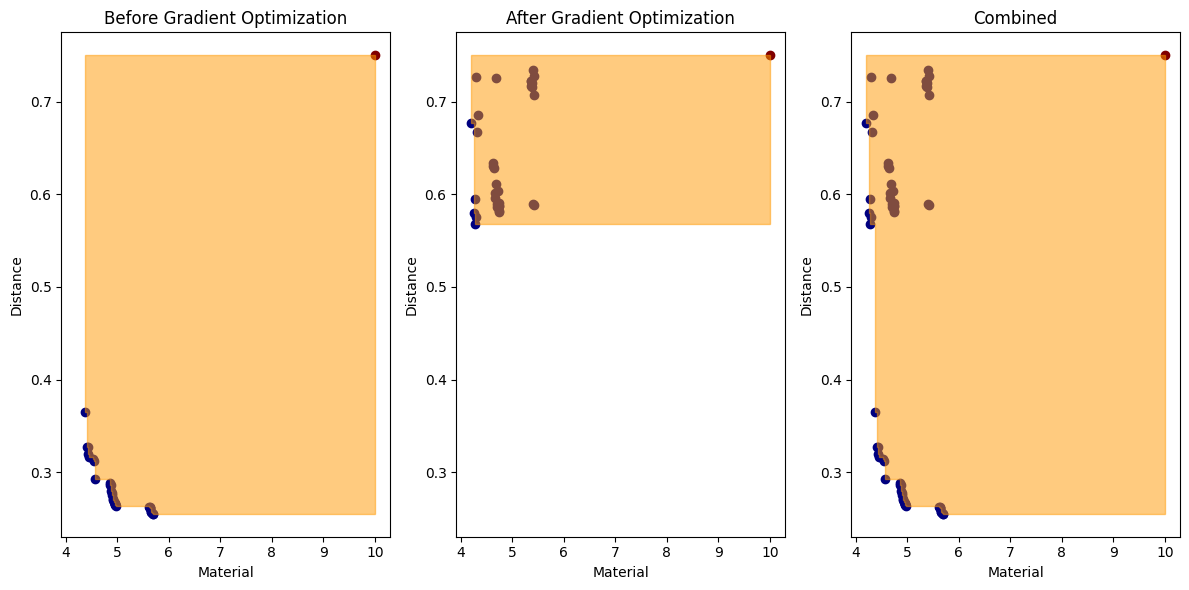

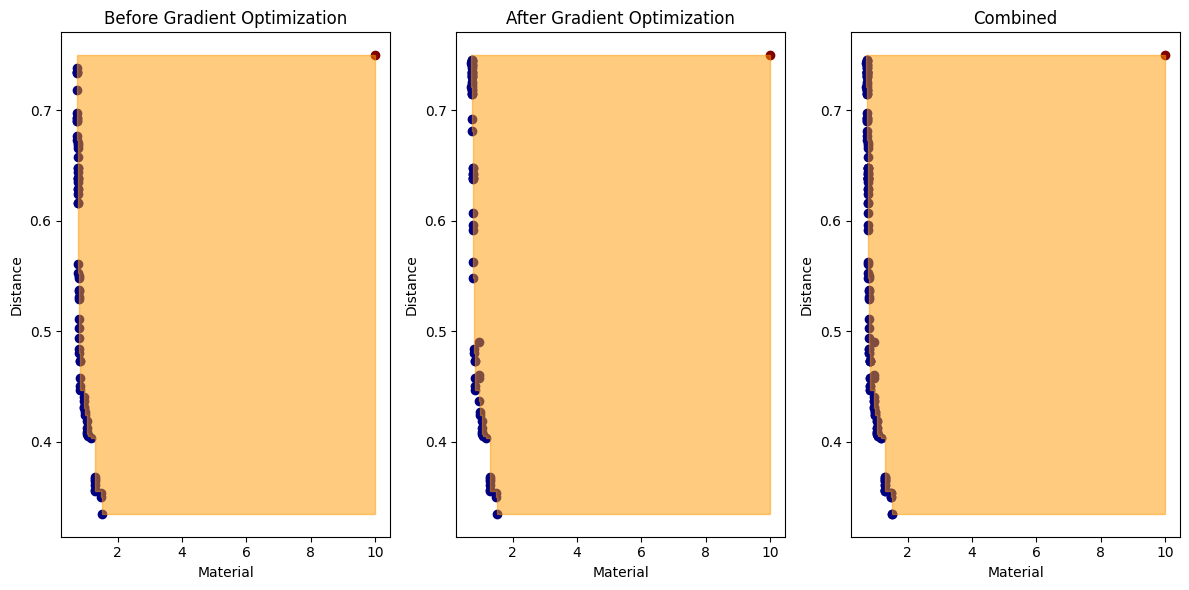

In [10]:
# Gradient Descent Optimization (material)
''' INIT '''
from LINKS.Optimization import DifferentiableTools
from utils.mechanism_io import load_mechanisms, save_mechanisms

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs
''' INIT End '''


''' Setup '''
STEP_SIZE = 4e-4
NUM_OF_STEPS = 1000 #default 1000
''' Setup End '''



for curve_index in curves:
    x0s = []
    edges = []
    fixed_joints = []
    motors = []
    #mechanisms = load_mechanisms(f'mechanisms_curve_{curve_index}_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}.npy')
    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))
    # print(mechanisms)
    for mech in mechanisms:
        x0s.append(mech['x0'])
        edges.append(mech['edges'])
        fixed_joints.append(mech['fixed_joints'])
        motors.append(mech['motor'])

    x = x0s.copy()

    # keep track of which members are done optimizing
    done_optimizing = np.zeros(len(x), dtype=bool)

    x_last = x.copy()

    for step in trange(NUM_OF_STEPS):
        
        # get current distances, materials and gradients
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )
        
        # only update members that are valid and not done optimizing
        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        
        # if a member is invalid, revert to last step and mark as done optimizing
        for i in invalids:
            done_optimizing[i] = True
            x[i] = x_last[i]
        
        # keep a copy of last step
        x_last = x.copy()

        # update valid members
        for i in valids:
            if done_optimizing[i]:
                continue
            x[i] = x[i] - STEP_SIZE * material_grads[i] #distance_grads[i]#distance_grads[i]#material_grads
            # x[i] = x[i] - STEP_SIZE * distance_grads[i]
            
        if np.all(done_optimizing):
            print(f'All members are done optimizing at step {step}')
            break


    F_before = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    F_after = np.array(
        PROBLEM_TOOLS(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors

    F_combo = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
        )).T
    
    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F_after)
    hv_combo = ind(F_combo)

    # VIZUALIZE
    print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization:  {hv_after:.4f}, combined:  {hv_combo:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ax1 = axes[0]
    ax1.set_title('Before Gradient Optimization')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('After Gradient Optimization')
    ga_visualizer.plot_HV(F_after, ref, objective_labels=['Distance', 'Material'], ax=ax2)

    ax3 = axes[2]
    ax3.set_title('Combined')
    ga_visualizer.plot_HV(F_combo, ref, objective_labels=['Distance', 'Material'], ax=ax3)


    # capture x/y limits from combined plot
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    #and apply for the first
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.tight_layout()


    # WRITE TO FILE
    mechanisms = []
    mech = {}
    for i in range(len(combined_x0s)):
        mech = {
                'x0': combined_x0s[i],
                'edges': combined_edges[i],
                'fixed_joints': combined_fixed_joints[i],
                'motor': combined_motors[i],
                #'target_joint': target_idx[i]
            }
        mechanisms.append(mech)

    file_name_temp = f'GD_material_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_STEP_SIZE_{STEP_SIZE}_NUM_OF_STEPS_{NUM_OF_STEPS}'

    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    # print(mechanisms)
    print(file_name)

file_name = file_name_temp


Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_0.npy numer of mechanisms: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0
Hypervolume before gradient optimization: 0.0000, after optimization:  0.0000, combined:  0.0000
Saved 200 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_0.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000
Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_1.npy numer of mechanisms: 136


  0%|          | 0/1000 [00:00<?, ?it/s]

Hypervolume before gradient optimization: 2.8292, after optimization:  2.8558, combined:  2.8634
Saved 272 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_1.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000
Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_2.npy numer of mechanisms: 48


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0
Hypervolume before gradient optimization: 0.0000, after optimization:  0.0000, combined:  0.0000
Saved 96 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_2.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000
Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_3.npy numer of mechanisms: 84


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 3
Hypervolume before gradient optimization: 2.8689, after optimization:  2.8683, combined:  2.8785
Saved 168 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_3.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000
Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_4.npy numer of mechanisms: 66


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 217
Hypervolume before gradient optimization: 2.7746, after optimization:  2.7354, combined:  2.7869
Saved 132 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_4.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000
Input file: GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_5.npy numer of mechanisms: 136


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 32
Hypervolume before gradient optimization: 3.7817, after optimization:  3.7798, combined:  3.7822
Saved 272 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_5.npy
GD_material_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000


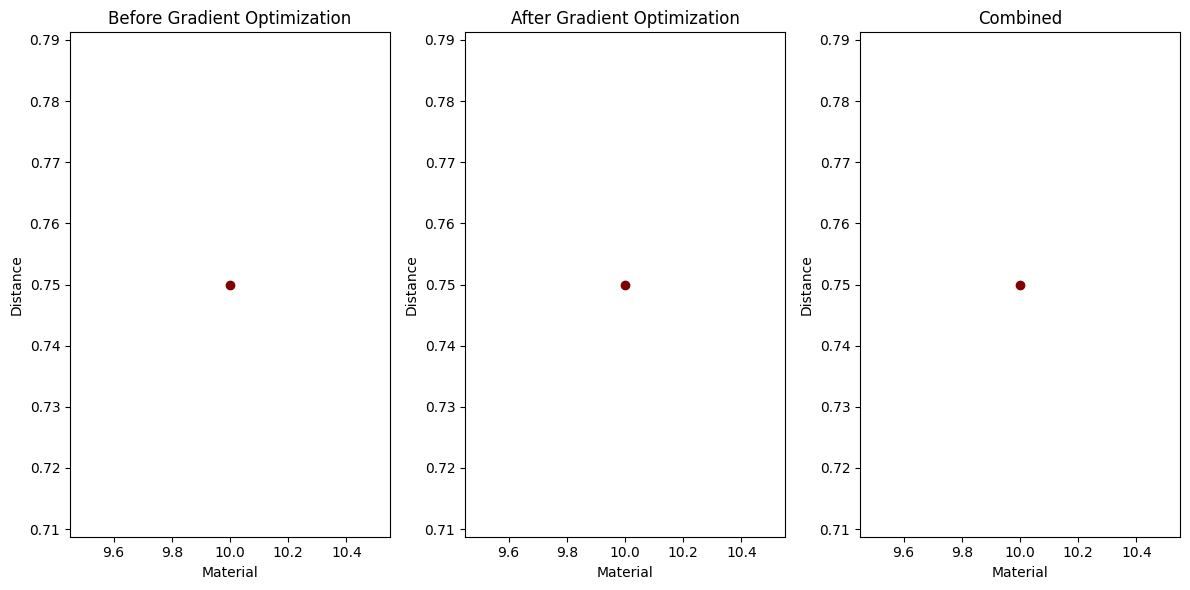

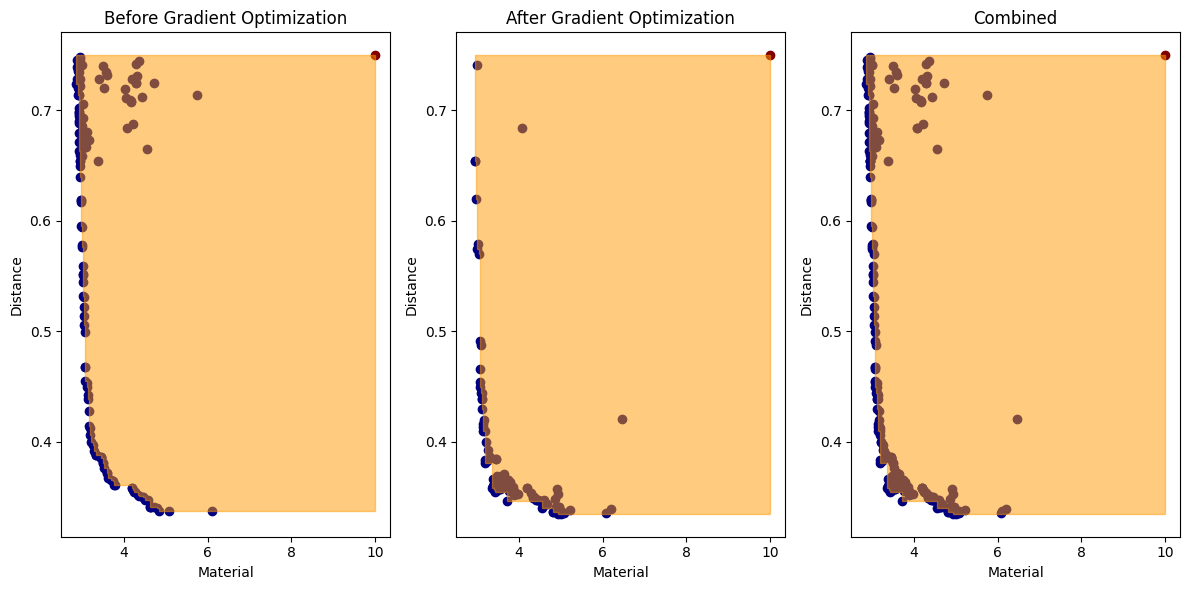

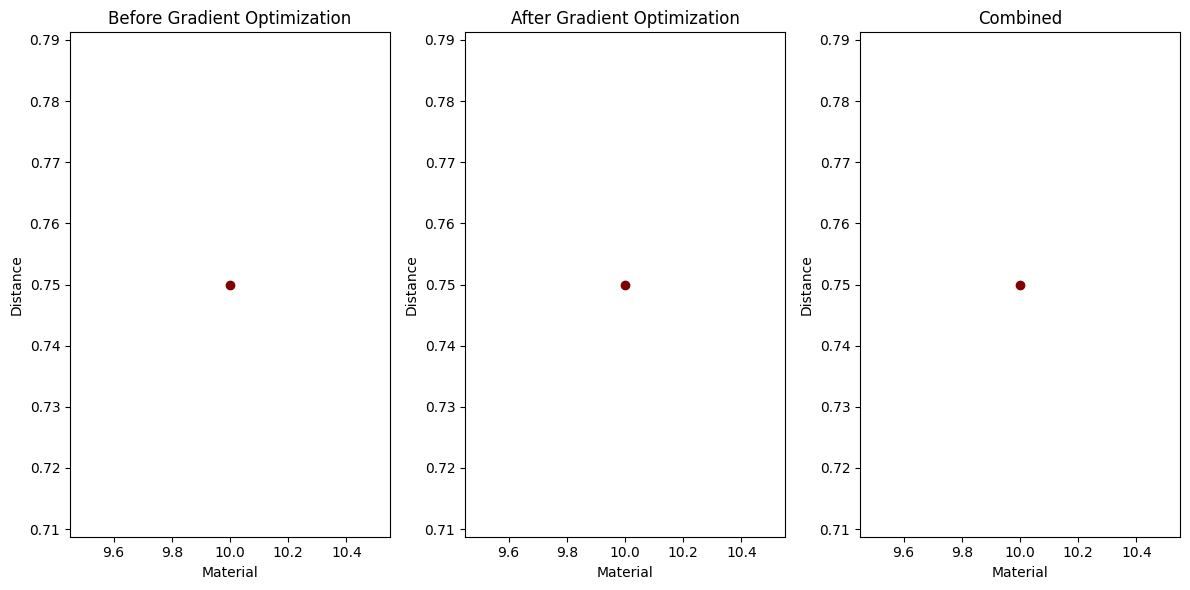

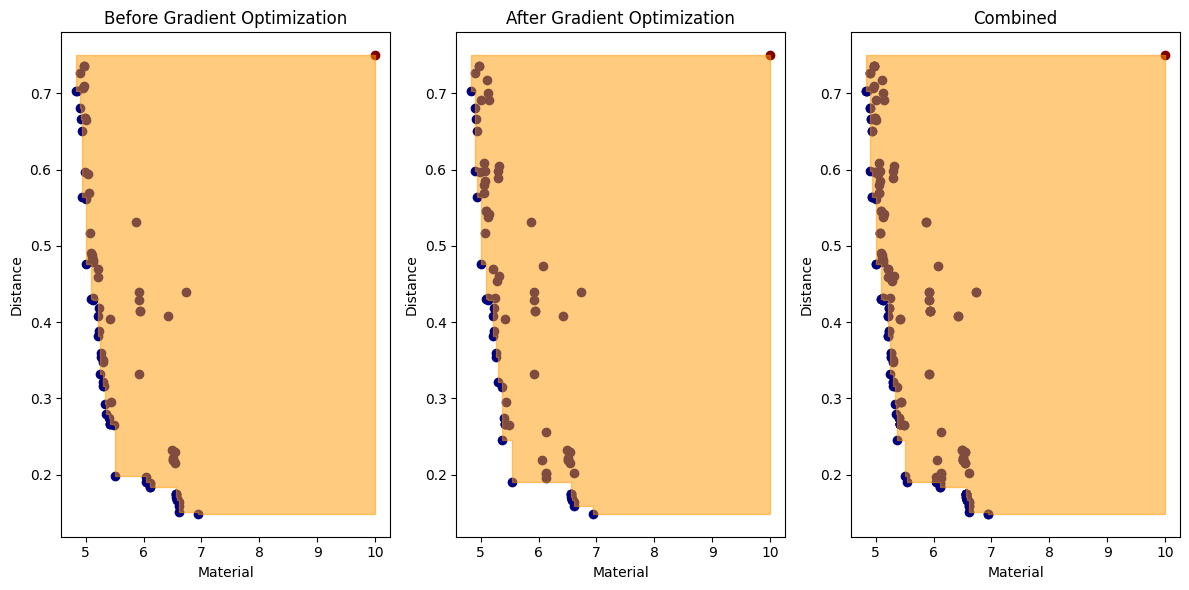

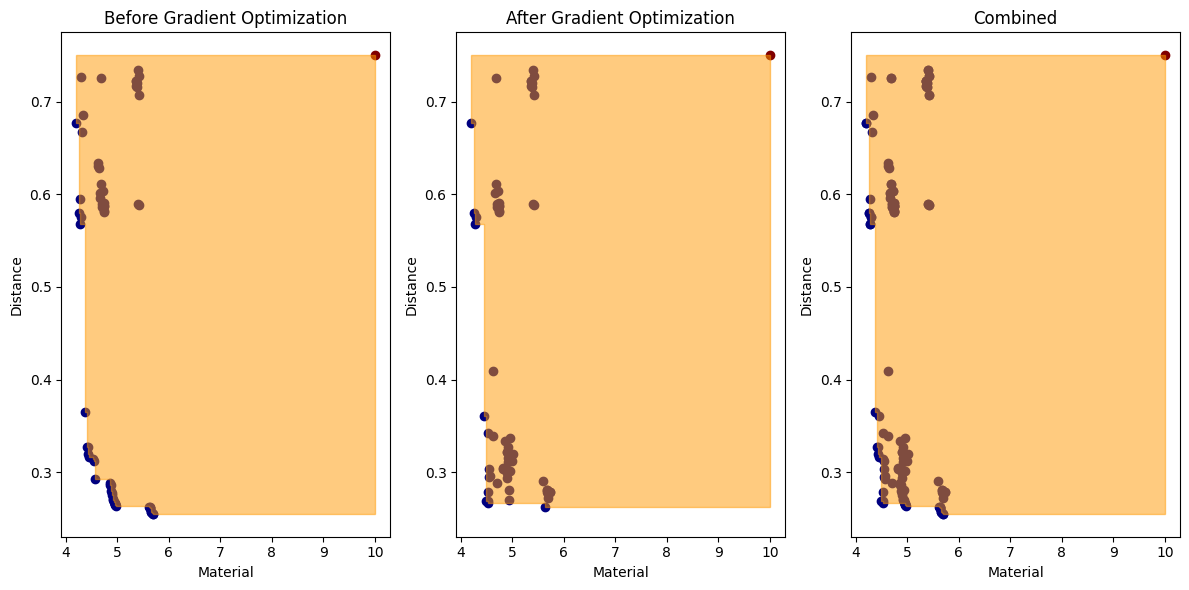

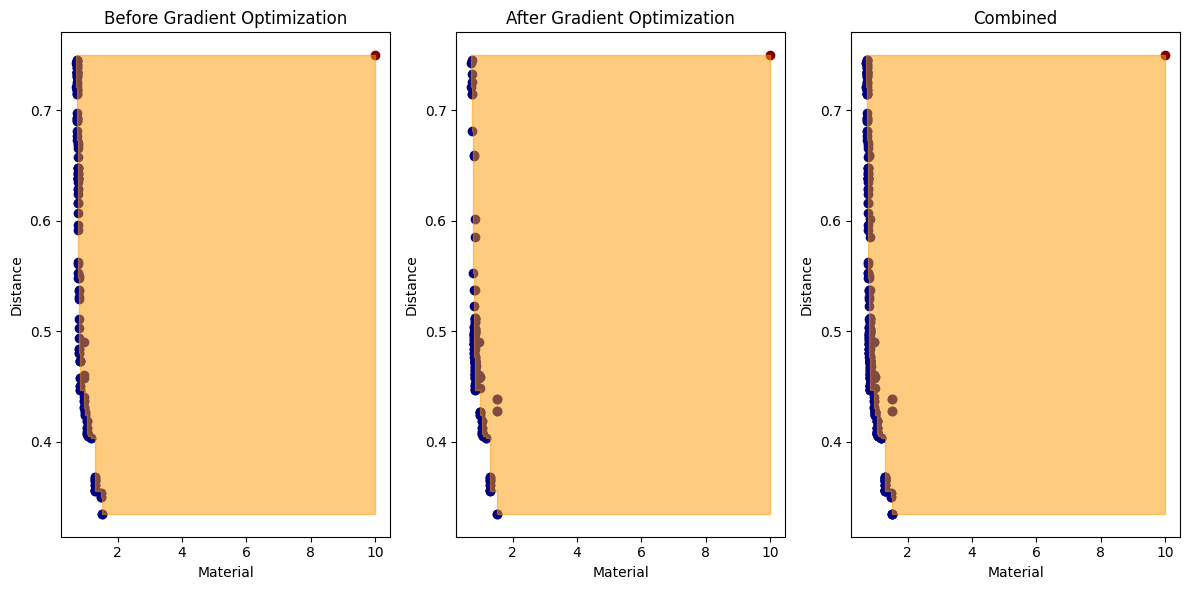

In [11]:
# Gradient Descent Optimization (distance)
''' INIT '''
from LINKS.Optimization import DifferentiableTools
from utils.mechanism_io import load_mechanisms, save_mechanisms

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs
''' INIT End '''


''' Setup '''
# # NUM_OF_NODES = 7
# # NUM_OF_MECH = 100
STEP_SIZE = STEP_SIZE
NUM_OF_STEPS = NUM_OF_STEPS #default 1000
''' Setup End '''



for curve_index in curves:
    x0s = []
    edges = []
    fixed_joints = []
    motors = []
    #mechanisms = load_mechanisms(f'mechanisms_curve_{curve_index}_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}.npy')
    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))

    for mech in mechanisms:
        x0s.append(mech['x0'])
        edges.append(mech['edges'])
        fixed_joints.append(mech['fixed_joints'])
        motors.append(mech['motor'])

    x = x0s.copy()

    # keep track of which members are done optimizing
    done_optimizing = np.zeros(len(x), dtype=bool)

    x_last = x.copy()

    for step in trange(NUM_OF_STEPS):
        
        # get current distances, materials and gradients
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )
        
        # only update members that are valid and not done optimizing
        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        
        # if a member is invalid, revert to last step and mark as done optimizing
        for i in invalids:
            done_optimizing[i] = True
            x[i] = x_last[i]
        
        # keep a copy of last step
        x_last = x.copy()

        # update valid members
        for i in valids:
            if done_optimizing[i]:
                continue
            x[i] = x[i] - STEP_SIZE * distance_grads[i]
            
        if np.all(done_optimizing):
            print(f'All members are done optimizing at step {step}')
            break


    F_before = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    F_after = np.array(
        PROBLEM_TOOLS(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors

    F_combo = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
        )).T
    
    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F_after)
    hv_combo = ind(F_combo)

    # VIZUALIZE
    print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization:  {hv_after:.4f}, combined:  {hv_combo:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ax1 = axes[0]
    ax1.set_title('Before Gradient Optimization')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('After Gradient Optimization')
    ga_visualizer.plot_HV(F_after, ref, objective_labels=['Distance', 'Material'], ax=ax2)

    ax3 = axes[2]
    ax3.set_title('Combined')
    ga_visualizer.plot_HV(F_combo, ref, objective_labels=['Distance', 'Material'], ax=ax3)


    # capture x/y limits from combined plot
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    #and apply for the first
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.tight_layout()

    # WRITE TO FILE
    mechanisms = []
    mech = {}
    for i in range(len(combined_x0s)):
        mech = {
                'x0': combined_x0s[i],
                'edges': combined_edges[i],
                'fixed_joints': combined_fixed_joints[i],
                'motor': combined_motors[i],
                #'target_joint': target_idx[i]
            }
        mechanisms.append(mech)

    file_name_temp = f'GD_distance_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_STEP_SIZE_{STEP_SIZE}_NUM_OF_STEPS_{NUM_OF_STEPS}'
    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    print(file_name)

file_name = file_name_temp


In [12]:
print(file_name)

GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000


In [13]:
file_name 

'GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000'

In [14]:
# Create submission from file
from LINKS.CP import make_empty_submission, evaluate_submission

# Genetic Algorithm Optimisation
from utils.mechanism_io import load_mechanisms

submission = make_empty_submission()
curves = [0,1,2,3,4,5]

for curve_index in curves:

    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))
    
    k = curve_index + 1
    for mech in mechanisms:
        submission[f'Problem {k}'].append(mech)
            
evaluate_submission(submission)
print(evaluate_submission(submission))
np.save(f'my_full_submission_{file_name}.npy', submission) 

Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_0.npy numer of mechanisms: 200
Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_1.npy numer of mechanisms: 272
Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_2.npy numer of mechanisms: 96
Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_3.npy numer of mechanisms: 168
Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_4.npy numer of mechanisms: 132
Input file: GD_distance_nodes_12_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000_curve_5.npy numer of mechanisms: 272
{'Overall Score': 2.0518161688338163, 'Score Breakdown': {'Problem 1': 0.0, 'Problem 2': 2.863360222320722, 'Problem 3': 0.0, 'Problem 4': 2.878503004788989, 'Problem 5': 2.7868667198698915, 'Problem 6': 3.7821670660232964}}


**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

In [46]:
print(curves)

[0, 1, 2, 3, 4, 5]


Now we can combine these new memebers with the old and see how the hypervolume changes:

### A Note On Scale Normalization

The functions that we saw in the starter notebool on curves, namely `compare_curves` and `visualize_comparison`, and `visualize_alignment` have a scaling option. An important input to the `CurveEngine` class is `normalize_scale`, which if set to `True` will rescale curves when comparing. In our problem we want this to be `False` since we care about the scale and material used in the problem. (We stress this distinction because the first component of the optimization demo had this rescaling turned on!)

Let's go back to the simple fourbar we had and see what this means:

Now let's visualize the alignment process with and without scale to understand what is going on: